In [1]:
import pandas as pd
import numpy as np
import time
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

import biomart
import prototypical_network
import helper_fns
import vanilla_vae
from model import PL, Net, train, train_knn, train_logistic_regression

In [2]:
dataset_celltypist = sc.read("/Volumes/SSD/global.h5ad")
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
list_celltypes = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_celltypes = list(filter(lambda x: x not in ['Mast cells', 'pDC','Progenitor', 'Erythroid', 'Megakaryocytes'], list_celltypes))
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_celltypes))
dataset_celltypist = dataset_celltypist[dataset_celltypist.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_celltypist.obs['Manually_curated_celltype'])

list_ct = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

g = helper_fns.build_hierarchical_tree_celltypist(all_nodes=all_nodes, list_ct=list_ct, list_inner_nodes=list_inner_nodes, encoder_celltype=encoder_celltype, encoder_celltype_inner=encoder_celltype_inner)

dist_df = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(dist_df.values, dtype=float)
ensembl_to_genesymbol = helper_fns.get_ensembl_mappings()

genes_celltypist = dataset_celltypist.var_names
genes_popv = dataset_popv.var_names
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

# filter the anndata by the found_ensembl genes
dataset_popv = dataset_popv[:,found_ensembl]
dataset_celltypist = dataset_celltypist[:,found_hgnc]

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_celltypist, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset_celltypist, 1e4)
sc.pp.log1p(dataset_celltypist)
# sc.pp.highly_variable_genes(dataset_celltypist)
# highly_variable_genes = dataset_celltypist.var['highly_variable']
# dataset_celltypist = dataset_celltypist[:,highly_variable_genes]
pca = TruncatedSVD(n_components=128, random_state=0)
pca.fit(dataset_celltypist[train_indices].X)
dataset_celltypist_pca = AnnData(pca.transform(dataset_celltypist.X))
dataset_celltypist_pca.obs = dataset_celltypist.obs

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=test_subsampler)


# Label encoder // No problem
encoder_celltype_popv = LabelEncoder()
encoder_celltype_popv.fit(dataset_popv.obs['cell_type'])

sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
# dataset_popv = dataset_popv[:,highly_variable_genes]
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset_popv.obs

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/xbh0403/Desktop/HCell/model.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  centers = torch.tensor(centers, dtype=float)


Epoch 1
Train ER 23.65, time 6.3s
Test ER 15.39, time 0.5s
Epoch 2
Train ER 13.05, time 5.9s
Test ER 11.85, time 0.5s
Epoch 3
Train ER 11.10, time 5.9s
Test ER 10.69, time 0.5s
Epoch 4
Train ER 9.93, time 5.8s
Test ER 9.68, time 0.6s
Epoch 5
Train ER 9.28, time 5.9s
Test ER 9.26, time 0.6s
Epoch 6
Train ER 8.84, time 5.9s
Test ER 8.96, time 0.6s
Epoch 7
Train ER 8.54, time 911.8s
Test ER 8.84, time 0.5s
Epoch 8
Train ER 8.37, time 5.9s
Test ER 8.68, time 0.6s
Epoch 9
Train ER 8.20, time 5.9s
Test ER 8.54, time 0.5s
Epoch 10
Train ER 8.09, time 6.0s
Test ER 8.69, time 0.5s
Epoch 11
Train ER 8.00, time 5.9s
Test ER 8.38, time 0.6s
Epoch 12
Train ER 7.93, time 5.9s
Test ER 8.41, time 0.6s
Epoch 13
Train ER 7.82, time 5.9s
Test ER 8.40, time 0.5s
Epoch 14
Train ER 7.77, time 5.9s
Test ER 8.32, time 0.6s
Epoch 15
Train ER 7.70, time 5.9s
Test ER 8.34, time 0.5s
Epoch 16
Train ER 7.68, time 6.0s
Test ER 8.32, time 940.5s
Epoch 17
Train ER 7.63, time 6.4s
Test ER 8.27, time 0.6s
Epoch 18
Trai

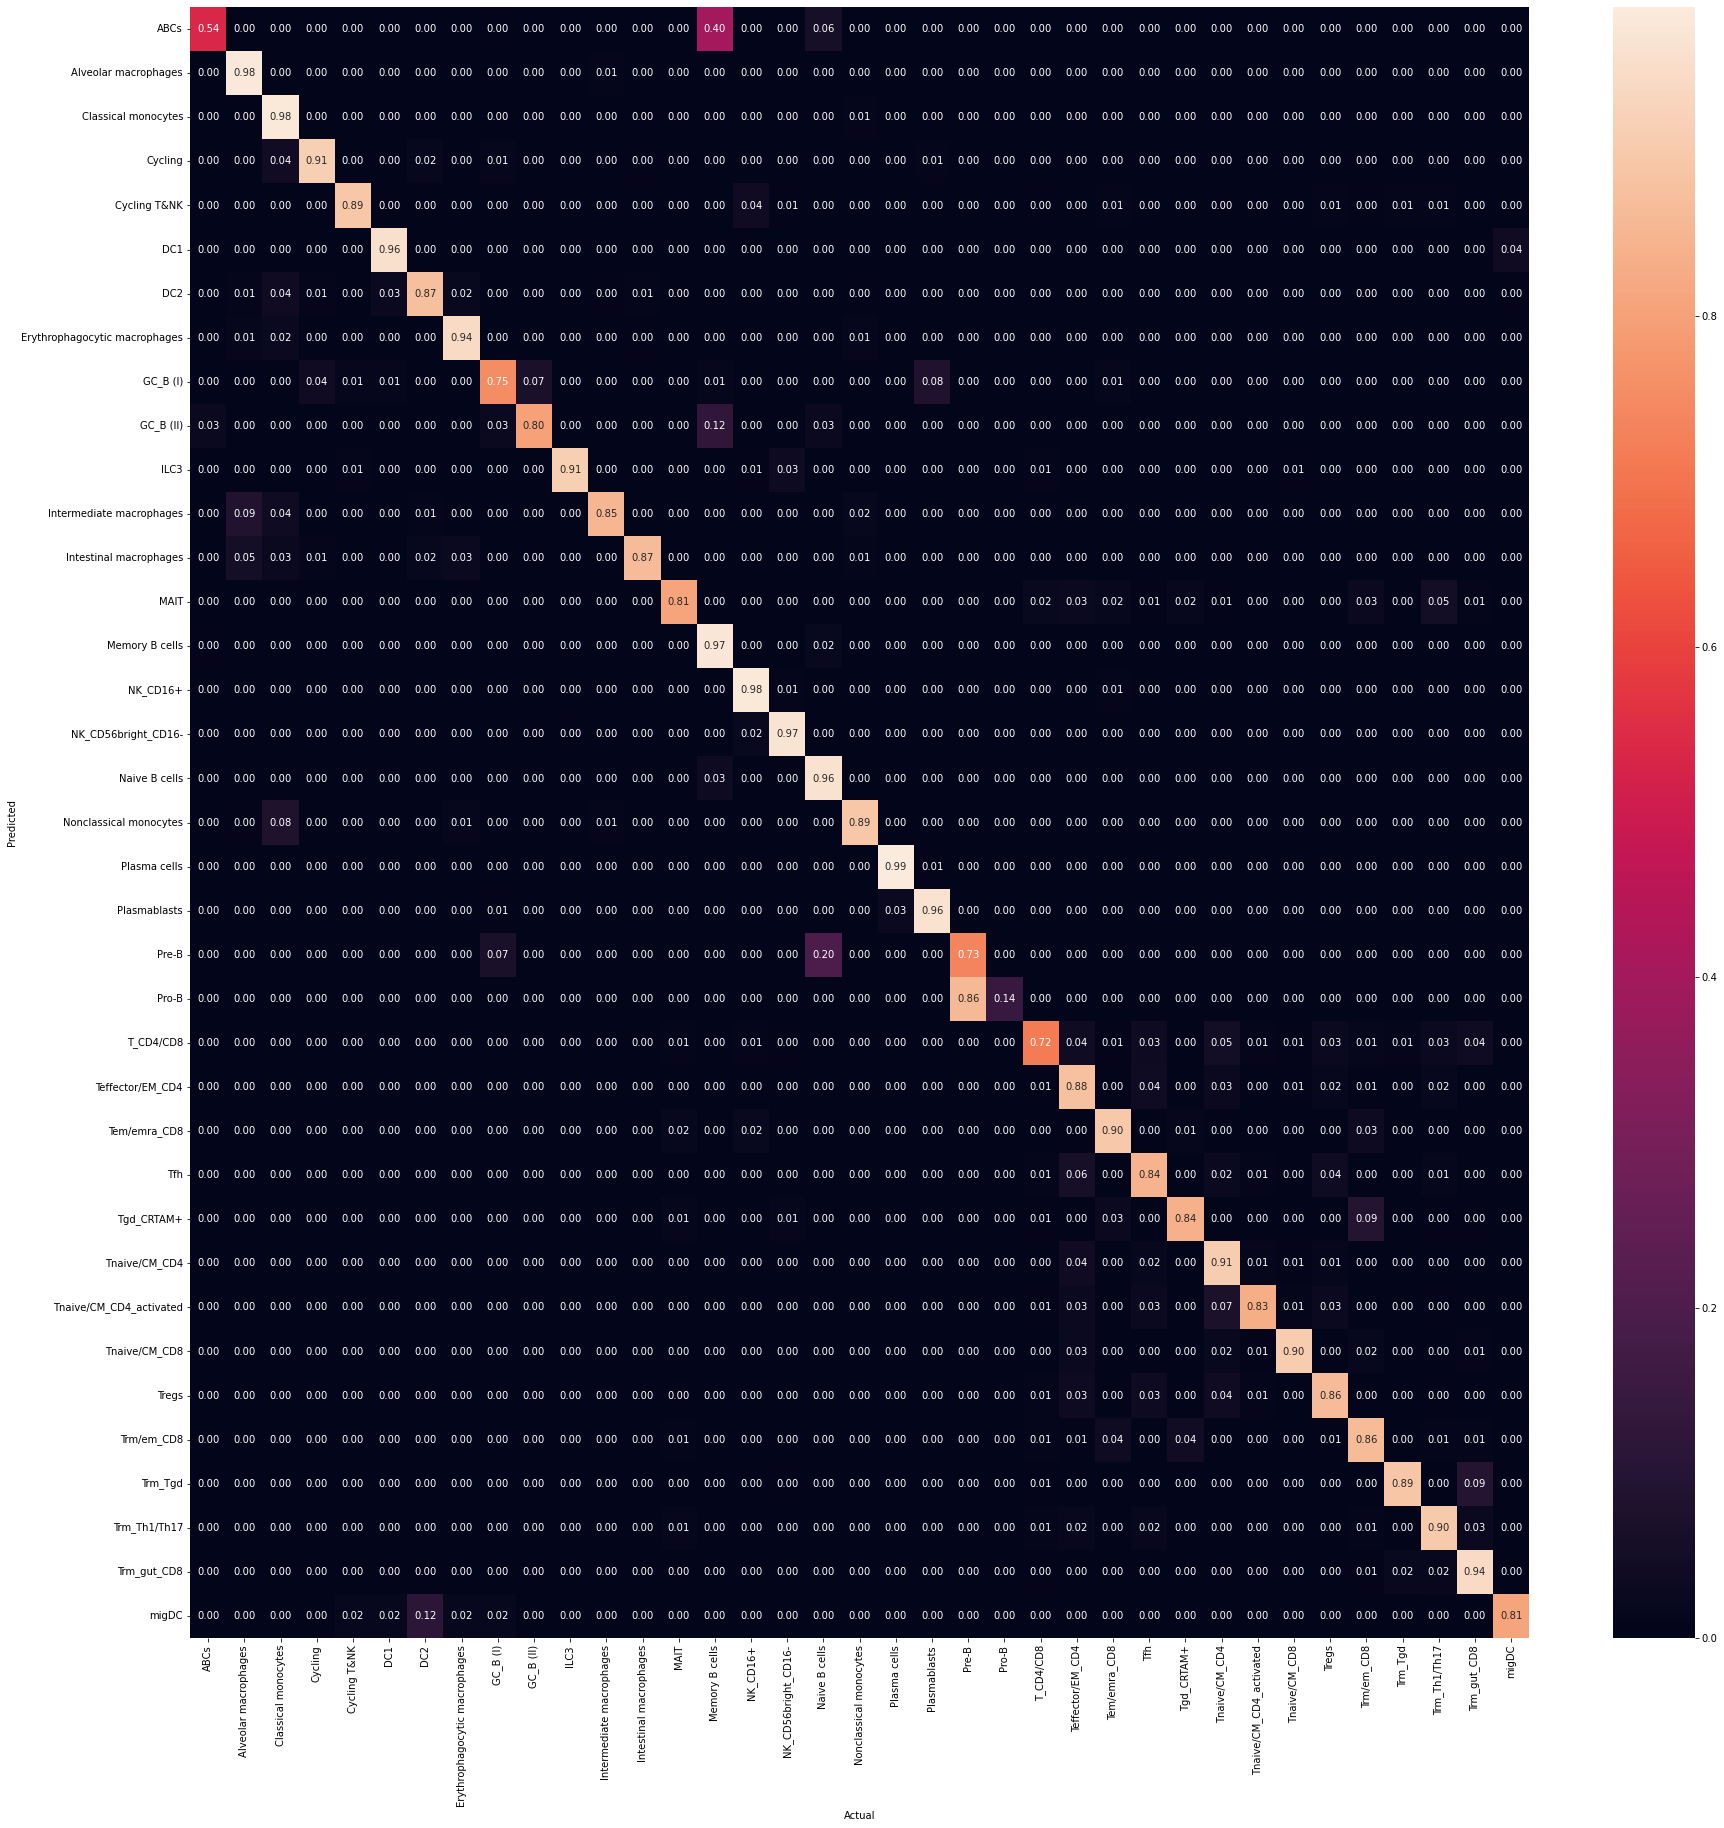

In [3]:
weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_celltypist, encoder=encoder_celltype, obs='Manually_curated_celltype')
model = train(mode='Proto_Net', loss_mode='disto_pl', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
    encoder=encoder_celltype, dataset=dataset_celltypist_pca, dataloader_training=dataloader_training, dataloader_testing=dataloader_testing, 
    obs_name='Manually_curated_celltype', init_weights=weights)
embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))
helper_fns.plot_confusion_matrix('Proto_Net', model, dataset=dataset_celltypist_pca, encoder=encoder_celltype, test_indices=test_indices, obs_name='Manually_curated_celltype')

In [4]:
model_logistic = train_logistic_regression(dataset=dataset_celltypist_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='Manually_curated_celltype')
model_knn = train_knn(dataset=dataset_celltypist_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='Manually_curated_celltype')

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 7.90691291220641%
Test error: 8.473751921930406%
kNN
Train error: 7.710465435438973%
Test error: 10.689070883931095%


In [5]:
train_celltypes = ['Memory B cells', 'Naive B cells', 'Tfh', 'Plasma cells', 'Tregs']
test_celltypes = ['memory B cell', 'naive B cell', 'T follicular helper cell', 'plasma cell', 'regulatory T cell']

In [6]:
train_embeddings, training_preds = helper_fns.get_embeddings_and_out(model, dataset_celltypist_pca[train_indices], encoder=encoder_celltype)
test_embeddings, test_preds = helper_fns.get_embeddings_and_out(model, dataset_popv_pca, encoder=encoder_celltype)
prototypes, prototypes_labels = helper_fns.get_prototypes_and_labels(model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

In [7]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Memory B cells', test_celltype='memory B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [8]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Naive B cells', test_celltype='naive B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [9]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tfh', test_celltype='T follicular helper cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [10]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Plasma cells', test_celltype='plasma cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [11]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tregs', test_celltype='regulatory T cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [12]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_popv_pca.obs['cell_type'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [13]:
# helper_fns.plot_embeddings_scatter(embeddings=train_embeddings, true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [14]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_celltypist_pca[test_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [15]:
# helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=training_preds, 
#     embeddings=train_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

In [16]:
# helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=test_preds, 
#     embeddings=test_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

In [17]:
def plot_dist_histogram(dict, graph, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save, model):
    true_label = dict['Celltype']
    # true_label = 'Memory B cells'
    dist_list = []
    for key in dict.keys():
        if key != 'Celltype' and key != 'true_positive_rate':
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner),
                helper_fns.transform(true_label, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), graph)
            for i in range(int(dict[key])):
                dist_list.append(dist)
    print(np.array(dist_list).mean())
    sns.displot(dist_list)
    # Add label to the plot
    plt.title(true_label)
    if save:
        plt.savefig('./plots_dist/histogram_' + model + true_label + '.png')
    else:
        plt.show()

In [18]:
'memory B cell' in list(dataset_popv_pca.obs['cell_type'].unique())

True

OUR MODEL


True positive memory B cell: 86.82699668282726%
{'Naive B cells': 933, 'ABCs': 718, 'Plasma cells': 61, 'DC2': 50, 'Tregs': 49, 'Plasmablasts': 44, 'GC_B (I)': 36, 'Tfh': 33, 'Cycling T&NK': 22, 'ILC3': 20, 'GC_B (II)': 20, 'Pre-B': 10, 'Tgd_CRTAM+': 7, 'Tnaive/CM_CD4': 7, 'Pro-B': 7, 'Teffector/EM_CD4': 6, 'Classical monocytes': 6, 'Cycling': 6, 'T_CD4/CD8': 5, 'Trm/em_CD8': 5, 'Tnaive/CM_CD8': 4, 'Erythrophagocytic macrophages': 4, 'Intestinal macrophages': 2, 'DC1': 2, 'Alveolar macrophages': 2, 'migDC': 2, 'Tem/emra_CD8': 2, 'Trm_Th1/Th17': 1, 'Intermediate macrophages': 1}
2.3501210653753026


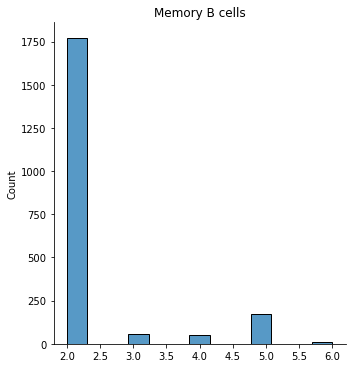



True positive naive B cell: 94.51264605827541%
{'Memory B cells': 320, 'ABCs': 20, 'DC2': 8, 'Tnaive/CM_CD4': 4, 'Plasmablasts': 3, 'NK_CD16+': 2, 'Cycling': 2, 'Pre-B': 2, 'Plasma cells': 2, 'Tnaive/CM_CD8': 1, 'ILC3': 1, 'Teffector/EM_CD4': 1, 'Tregs': 1, 'Tem/emra_CD8': 1, 'Classical monocytes': 1, 'Cycling T&NK': 1, 'NK_CD56bright_CD16-': 1}
2.1940700808625335


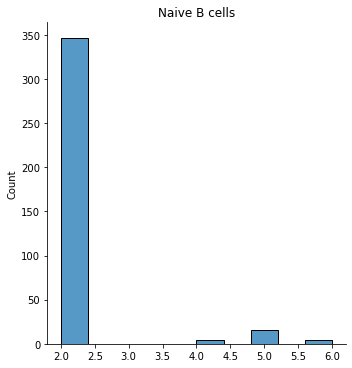



True positive T follicular helper cell: 27.386934673366838%
{'Tnaive/CM_CD4': 149, 'Teffector/EM_CD4': 85, 'Trm_Th1/Th17': 32, 'Tregs': 13, 'Tnaive/CM_CD8': 7, 'Trm_gut_CD8': 1, 'T_CD4/CD8': 1, 'MAIT': 1}
2.58477508650519


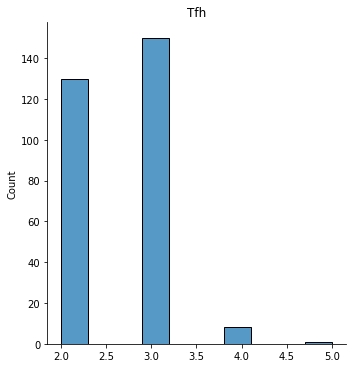



True positive plasma cell: 58.47553053269814%
{'Plasmablasts': 4150, 'NK_CD16+': 510, 'NK_CD56bright_CD16-': 32, 'Memory B cells': 13, 'Cycling': 12, 'ILC3': 11, 'Trm/em_CD8': 9, 'Cycling T&NK': 7, 'Alveolar macrophages': 6, 'ABCs': 5, 'Teffector/EM_CD4': 5, 'Naive B cells': 4, 'Trm_Th1/Th17': 4, 'GC_B (I)': 3, 'T_CD4/CD8': 3, 'Pro-B': 3, 'Intestinal macrophages': 3, 'Tem/emra_CD8': 3, 'Pre-B': 2, 'Classical monocytes': 2, 'Trm_Tgd': 2, 'MAIT': 1, 'Intermediate macrophages': 1, 'Nonclassical monocytes': 1, 'DC2': 1, 'Erythrophagocytic macrophages': 1}
2.3798498122653315


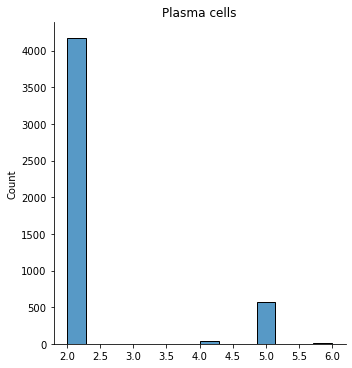



True positive regulatory T cell: 83.34612432847275%
{'Cycling T&NK': 63, 'Teffector/EM_CD4': 36, 'Tfh': 33, 'Tnaive/CM_CD4': 21, 'Memory B cells': 18, 'Trm/em_CD8': 12, 'Trm_Th1/Th17': 12, 'ILC3': 5, 'Tgd_CRTAM+': 4, 'T_CD4/CD8': 3, 'MAIT': 3, 'NK_CD56bright_CD16-': 2, 'Tnaive/CM_CD4_activated': 1, 'Classical monocytes': 1, 'Naive B cells': 1, 'Plasma cells': 1, 'Tnaive/CM_CD8': 1}
2.9815668202764978


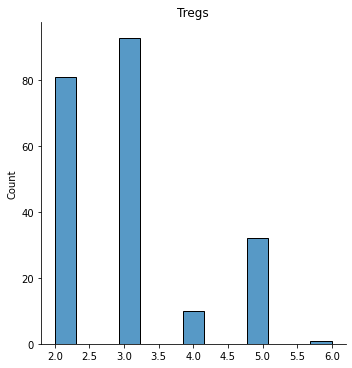



Logistic Regression


True positive memory B cell: 86.5335544781832%
{'Naive B cells': 910, 'ABCs': 692, 'DC2': 95, 'GC_B (I)': 84, 'Pro-B': 79, 'Tregs': 54, 'Plasmablasts': 37, 'GC_B (II)': 33, 'Plasma cells': 30, 'Tfh': 12, 'ILC3': 10, 'Tnaive/CM_CD4': 10, 'Trm/em_CD8': 8, 'Tnaive/CM_CD8': 7, 'T_CD4/CD8': 6, 'Cycling': 6, 'Cycling T&NK': 6, 'migDC': 6, 'Classical monocytes': 5, 'Teffector/EM_CD4': 4, 'Erythrophagocytic macrophages': 4, 'Alveolar macrophages': 3, 'Tem/emra_CD8': 3, 'Pre-B': 3, 'DC1': 2, 'Trm_Th1/Th17': 1, 'Intermediate macrophages': 1}
2.396020843202274


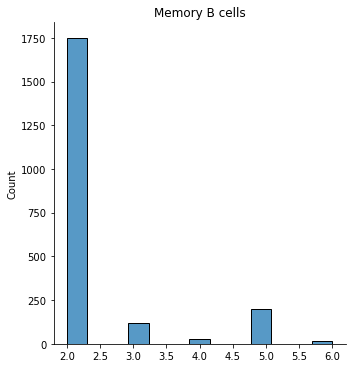



True positive naive B cell: 94.71971601834048%
{'Memory B cells': 318, 'ABCs': 13, 'Tnaive/CM_CD4': 5, 'Pro-B': 4, 'DC2': 3, 'GC_B (I)': 2, 'Classical monocytes': 2, 'Plasmablasts': 2, 'Tnaive/CM_CD8': 1, 'Trm/em_CD8': 1, 'NK_CD16+': 1, 'Tem/emra_CD8': 1, 'GC_B (II)': 1, 'Tregs': 1, 'Cycling': 1, 'Plasma cells': 1}
2.156862745098039


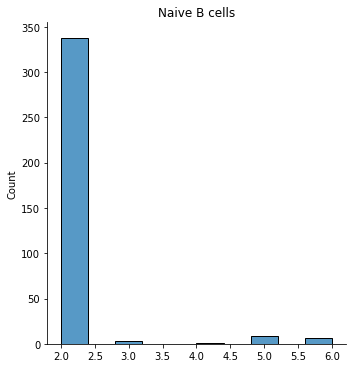



True positive T follicular helper cell: 28.391959798994975%
{'Tnaive/CM_CD4': 154, 'Teffector/EM_CD4': 84, 'Trm_Th1/Th17': 26, 'Tregs': 9, 'Tnaive/CM_CD8': 7, 'Trm_gut_CD8': 3, 'T_CD4/CD8': 1, 'Trm/em_CD8': 1}
2.635087719298246


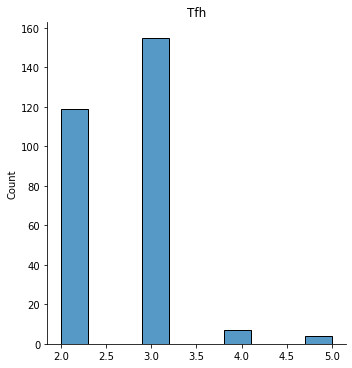



True positive plasma cell: 59.02122130792551%
{'Plasmablasts': 4076, 'NK_CD16+': 507, 'NK_CD56bright_CD16-': 32, 'Cycling': 18, 'GC_B (I)': 15, 'Memory B cells': 14, 'DC2': 11, 'ILC3': 8, 'Classical monocytes': 6, 'ABCs': 5, 'Tem/emra_CD8': 5, 'Cycling T&NK': 5, 'Alveolar macrophages': 5, 'Tnaive/CM_CD4': 3, 'Trm_Th1/Th17': 3, 'Intestinal macrophages': 3, 'Erythrophagocytic macrophages': 3, 'Naive B cells': 2, 'T_CD4/CD8': 2, 'Tregs': 1, 'Pro-B': 1, 'GC_B (II)': 1, 'Teffector/EM_CD4': 1, 'MAIT': 1, 'DC1': 1, 'Trm/em_CD8': 1, 'Intermediate macrophages': 1}
2.3885013739167196


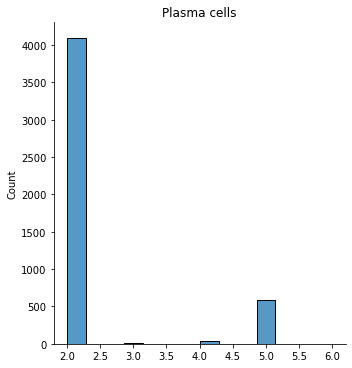



True positive regulatory T cell: 83.49961627014582%
{'Cycling T&NK': 61, 'Tfh': 43, 'Teffector/EM_CD4': 31, 'Tnaive/CM_CD4': 26, 'Trm/em_CD8': 11, 'Memory B cells': 9, 'Trm_Th1/Th17': 9, 'Pro-B': 8, 'MAIT': 4, 'Tgd_CRTAM+': 3, 'ILC3': 3, 'Tnaive/CM_CD4_activated': 2, 'Naive B cells': 1, 'Classical monocytes': 1, 'NK_CD56bright_CD16-': 1, 'Plasma cells': 1, 'Tnaive/CM_CD8': 1}
2.9488372093023254


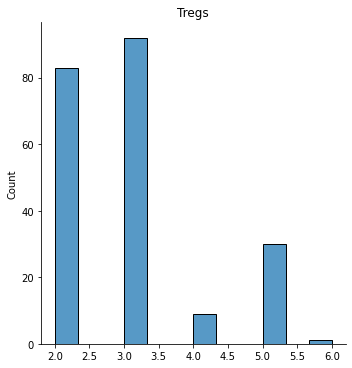



kNN


True positive memory B cell: 91.57310538402653%
{'Naive B cells': 733, 'ABCs': 215, 'Plasmablasts': 63, 'GC_B (I)': 51, 'Tregs': 43, 'DC2': 37, 'GC_B (II)': 28, 'Teffector/EM_CD4': 21, 'Plasma cells': 21, 'Classical monocytes': 16, 'Tnaive/CM_CD4': 13, 'T_CD4/CD8': 12, 'ILC3': 11, 'Tfh': 11, 'Tem/emra_CD8': 10, 'Cycling T&NK': 7, 'Cycling': 6, 'Tnaive/CM_CD8': 6, 'Trm/em_CD8': 5, 'Erythrophagocytic macrophages': 5, 'Pro-B': 3, 'migDC': 2, 'Intestinal macrophages': 1, 'Tnaive/CM_CD4_activated': 1}
2.5170325510976532


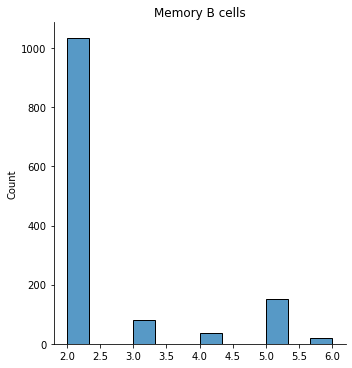



True positive naive B cell: 92.5159000147907%
{'Memory B cells': 481, 'Classical monocytes': 5, 'Tem/emra_CD8': 4, 'Tnaive/CM_CD4': 4, 'ABCs': 3, 'Plasmablasts': 3, 'NK_CD16+': 2, 'Tnaive/CM_CD8': 1, 'T_CD4/CD8': 1, 'GC_B (I)': 1, 'Plasma cells': 1}
2.108695652173913


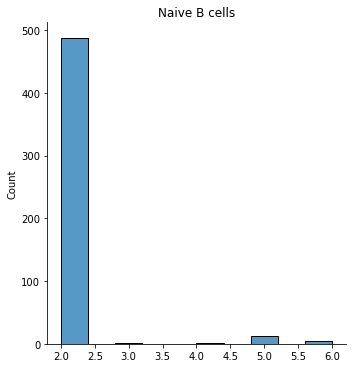



True positive T follicular helper cell: 23.869346733668344%
{'Tnaive/CM_CD4': 191, 'Teffector/EM_CD4': 57, 'Trm_Th1/Th17': 18, 'Tregs': 16, 'Tnaive/CM_CD8': 11, 'T_CD4/CD8': 6, 'Trm_gut_CD8': 2, 'MAIT': 2}
2.7557755775577557


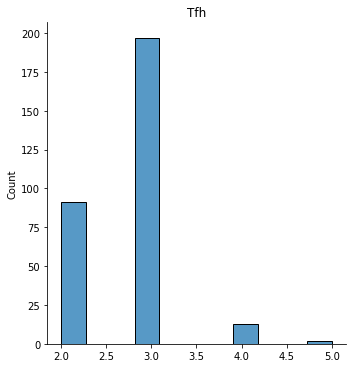



True positive plasma cell: 57.58336942399307%
{'Plasmablasts': 4250, 'NK_CD16+': 526, 'T_CD4/CD8': 17, 'Tem/emra_CD8': 17, 'NK_CD56bright_CD16-': 15, 'Memory B cells': 11, 'Alveolar macrophages': 11, 'Cycling T&NK': 8, 'GC_B (I)': 6, 'DC2': 6, 'Trm/em_CD8': 5, 'Naive B cells': 4, 'ABCs': 4, 'Classical monocytes': 4, 'Cycling': 2, 'Trm_Th1/Th17': 2, 'Intestinal macrophages': 2, 'Erythrophagocytic macrophages': 2, 'GC_B (II)': 1, 'Tgd_CRTAM+': 1, 'ILC3': 1, 'Teffector/EM_CD4': 1, 'Tregs': 1}
2.3771696957320807


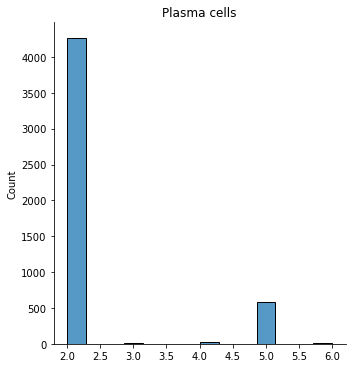



True positive regulatory T cell: 73.67613200306984%
{'Tfh': 96, 'Tnaive/CM_CD4': 71, 'Cycling T&NK': 64, 'Teffector/EM_CD4': 36, 'Memory B cells': 26, 'Trm/em_CD8': 12, 'Trm_Th1/Th17': 8, 'MAIT': 7, 'T_CD4/CD8': 5, 'Tem/emra_CD8': 4, 'Tnaive/CM_CD4_activated': 3, 'Tgd_CRTAM+': 3, 'ILC3': 3, 'Tnaive/CM_CD8': 2, 'Naive B cells': 1, 'Classical monocytes': 1, 'NK_CD56bright_CD16-': 1}
2.877551020408163


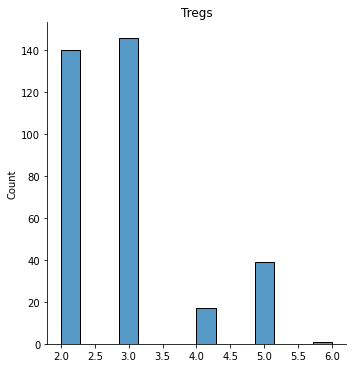

In [19]:
print("OUR MODEL")
wrong_dict_our_model_list = []
for i in range(len(train_celltypes)):
    print('\n')
    wrong_dict_our_model = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_dict_our_model, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='our_model')
    wrong_dict_our_model_list.append(wrong_dict_our_model)

print('\n')
print("Logistic Regression")
wrong_dict_logistic_regression_list = []
test_preds_logistic = encoder_celltype.inverse_transform(model_logistic.predict(dataset_popv_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    wrong_dict_logistic = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds_logistic, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_dict_logistic, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='logistic_regression')
    wrong_dict_logistic_regression_list.append(wrong_dict_logistic)

print('\n')
print("kNN")
wrong_dict_knn_list = []
test_preds_knn = encoder_celltype.inverse_transform(model_knn.predict(dataset_popv_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    wrong_pred_knn = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds_knn, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_pred_knn, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='knn')
    wrong_dict_knn_list.append(wrong_pred_knn)

In [21]:
df_acc = pd.DataFrame(columns=['celltype', 'true_positive_rate', 'model'])
for i in range(len(wrong_dict_our_model_list)):
    # Fill temp_df with the true positive rate for each cell type using pd.concat
    a = pd.DataFrame({
        'celltype': [wrong_dict_our_model_list[i]['Celltype'], wrong_dict_logistic_regression_list[i]['Celltype'], wrong_dict_knn_list[i]['Celltype']],
        'true_positive_rate': [wrong_dict_our_model_list[i]['true_positive_rate'], wrong_dict_logistic_regression_list[i]['true_positive_rate'], wrong_dict_knn_list[i]['true_positive_rate']],
        'model': ['our_model', 'logistic_regression', 'knn']
        })
    df_acc = pd.concat([df_acc, a], ignore_index=True)

In [22]:
df_dist = pd.DataFrame(columns=['celltype', 'pred_celltype', 'dist', 'model'])
for n in range(len(wrong_dict_our_model_list)):
    for key in wrong_dict_our_model_list[n].keys():
        celltype = wrong_dict_our_model_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_our_model_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'our_model']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

    for key in wrong_dict_logistic_regression_list[n].keys():
        celltype = wrong_dict_logistic_regression_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_logistic_regression_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'logistic']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

    for key in wrong_dict_knn_list[n].keys():
        celltype = wrong_dict_knn_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_knn_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'knn']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

In [23]:
mean_dist_our_model = [2.330293819655522, 2.1398416886543536, 2.671232876712329, 2.3760577915376677, 3.1973684210526314]
mean_dist_logistic = [2.567415730337079, 2.13986013986014, 2.6486486486486487, 2.4160771704180064, 3.0558375634517767]
mean_dist_knn = [2.4720048163756774, 2.0915805022156575, 2.6055555555555556, 2.2909618998804033, 3.0334075723830733]
df_mean_dist = pd.DataFrame(columns=['celltype', 'mean_dist', 'model'])
for i in range(len(mean_dist_our_model)):
    # Fill temp_df with the true positive rate for each cell type using pd.concat
    a = pd.DataFrame({
        'celltype': [wrong_dict_our_model_list[i]['Celltype'], wrong_dict_logistic_regression_list[i]['Celltype'], wrong_dict_knn_list[i]['Celltype']],
        'mean_dist': [mean_dist_our_model[i], mean_dist_logistic[i], mean_dist_knn[i]],
        'model': ['our_model', 'logistic_regression', 'knn']
        })
    df_mean_dist = pd.concat([df_mean_dist, a], ignore_index=True)

# train_err = [7.30, 8.498608006901154, 8.553111398658986]
# test_err = [8.80, 9.04954658131727, 11.832815588816715]
df_err = pd.DataFrame(columns=['error', 'model', 'type'])
a = pd.DataFrame({
    'error': [7.30, 8.80, 8.498608006901154, 9.04954658131727, 8.553111398658986, 11.832815588816715],
    'model': ['our_model', 'our_model', 'logistic_regression', 'logistic_regression', 'knn', 'knn'],
    'type': ['train', 'test', 'train', 'test', 'train', 'test']
    })
df_err = pd.concat([df_err, a], ignore_index=True)

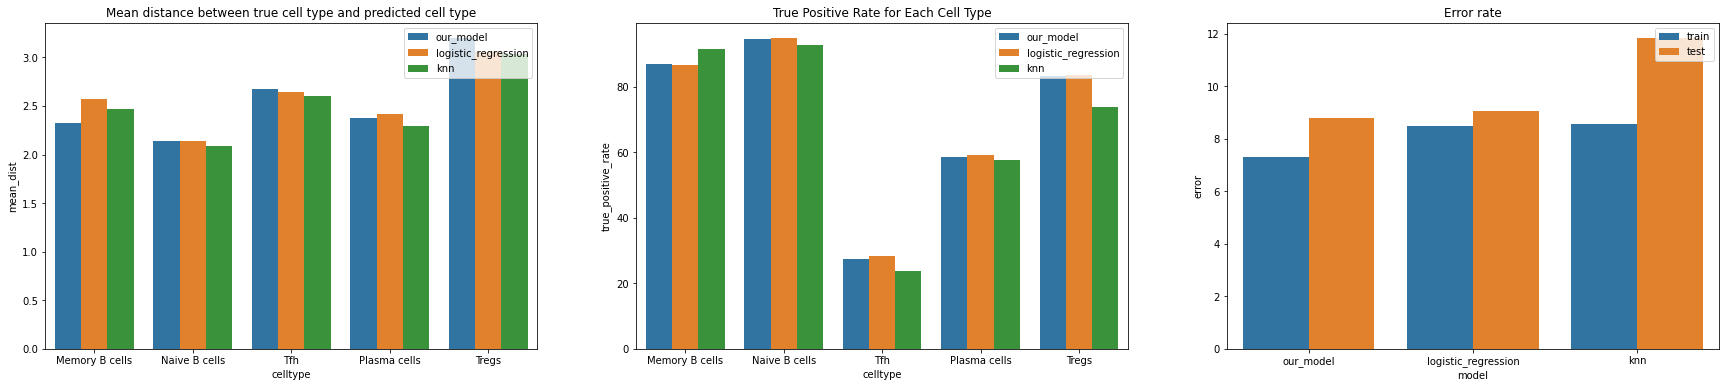

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
sns.barplot(x='celltype', y='mean_dist', hue='model', data=df_mean_dist, ax=ax1)
ax1.set_title('Mean distance between true cell type and predicted cell type')
ax1.legend(loc='upper right')
ax2 = sns.barplot(data=df_acc, x='celltype', y='true_positive_rate', hue='model', ax=ax2)
ax2.set_title('True Positive Rate for Each Cell Type')
ax2.legend(loc='upper right')
ax3 = sns.barplot(data=df_err, x='model', y='error', hue='type', ax=ax3)
ax3.set_title('Error rate')
ax3.legend(loc='upper right')
plt.show()

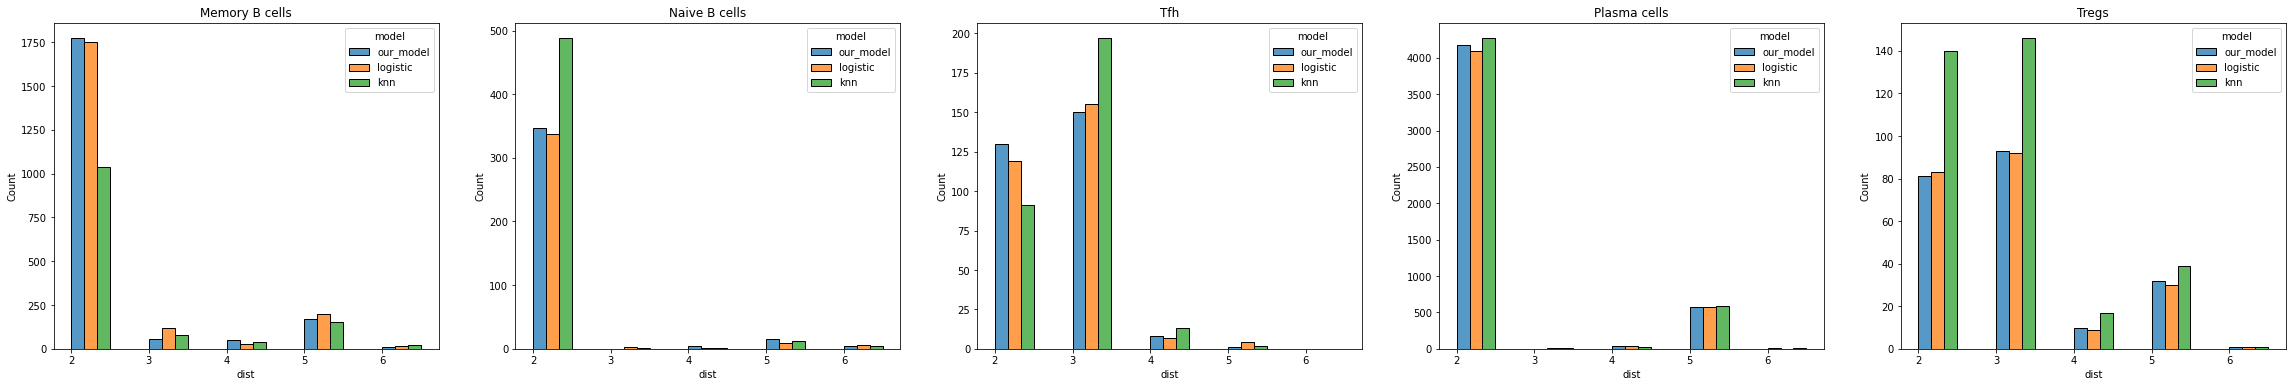

In [25]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
fig.set_size_inches(40, 6)
# ax0 = sns.barplot(data=df_acc, x='celltype', y='true_positive_rate', hue='model', ax=ax0)
# ax0.set_title('True Positive Rate for Each Cell Type')
# ax0.legend(loc='upper right')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Memory B cells'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax1)
ax1.set_title('Memory B cells')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Naive B cells'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax2)
ax2.set_title('Naive B cells')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Tfh'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax3)
ax3.set_title('Tfh')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Plasma cells'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax4)
ax4.set_title('Plasma cells')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Tregs'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax5)
ax5.set_title('Tregs')
plt.show()